In [1]:
from readii.negative_controls_refactor.manager import NegativeControlManager
from pathlib import Path
import pandas as pd
import SimpleITK as sitk
import numpy as np
from collections import OrderedDict
from radiomics import featureextractor, setVerbosity
from readii.utils import logger
setVerbosity(50)

In [ ]:
# filepath setup
DATA_SOURCE = "TCIA"
DATASET_NAME = "CC-Radiomics-Phantom"
DATA_DIR = Path("../data/procdata", f"{DATA_SOURCE}_{DATASET_NAME}")
MIT_INDEX_DIR = "mit_" + DATASET_NAME
pyrad_output_path = DATA_DIR / "pyradiomics_features"
RESULTS_DIR = Path("../data/results", f"{DATA_SOURCE}_{DATASET_NAME}", "pyradiomics_features")

RANDOM_SEED = 10

In [3]:
def flatten_image(image: sitk.Image) -> sitk.Image:
    """Remove axes of image with size one. (ex. shape is [1, 100, 256, 256])

    Parameters
    ----------
    image : sitk.Image
        Image to remove axes with size one.

    Returns
    -------
    sitk.Image
        image with axes of length one removed.
    """
    imageArr = sitk.GetArrayFromImage(image)

    imageArr = np.squeeze(imageArr)

    return sitk.GetImageFromArray(imageArr)

In [4]:
manager = NegativeControlManager.from_strings(
    negative_control_types=["randomized", "shuffled", "sampled"],
    region_types=["roi", "non_roi", "full"],
    random_seed=RANDOM_SEED,
)

In [ ]:
params = "../src/readii/data/shape_only_pyradiomics.yaml"
extractor = featureextractor.RadiomicsFeatureExtractor(params)

pyrad_dataset_df = pd.read_csv(DATA_DIR / f"pyradiomics_features/pyrad_{DATASET_NAME}_index.csv")

total_sample_count = len(pyrad_dataset_df)
for idx, sample_row in pyrad_dataset_df.iterrows():
    print(f"Processing {sample_row.ID} ({idx+1}/{total_sample_count})")
    sample_image = flatten_image(sitk.ReadImage(sample_row.Image))
    sample_mask = flatten_image(sitk.ReadImage(sample_row.Mask))

    sample_feature_dir = pyrad_output_path / Path(params).stem / sample_row.ID
    sample_feature_dir.mkdir(parents=True, exist_ok=True)

    for neg_image, control_strategy_name, region_strategy_name in manager.apply(sample_image, sample_mask):
        try:
            sample_feature_vector = pd.Series(extractor.execute(neg_image, sample_mask))
        except Exception as e:
            print("Feature extraction failed: ", e)
        
        # Start the result dictionary with the sample info (must convert within this loop to create new result dict every time)
        result_dict = sample_row.to_dict(into=OrderedDict)
        # Append the extracted features to the result dictionary
        result_dict.update(sample_feature_vector)
        
        # Set up output file name with negative control info
        sample_result_file_name = f"{sample_row.ID}_{control_strategy_name}_{region_strategy_name}_features.csv"
        # save out the features for this negative control sample combination
        result_ser = pd.Series(result_dict).to_csv((sample_feature_dir / sample_result_file_name))

Processing NSCLC-Radiomics_001 (0/421)
Processing NSCLC-Radiomics_002 (1/421)
Processing NSCLC-Radiomics_003 (2/421)
Processing NSCLC-Radiomics_004 (3/421)
Processing NSCLC-Radiomics_005 (4/421)
Processing NSCLC-Radiomics_006 (5/421)
Processing NSCLC-Radiomics_007 (6/421)
Processing NSCLC-Radiomics_008 (7/421)
Processing NSCLC-Radiomics_009 (8/421)
Processing NSCLC-Radiomics_010 (9/421)
Processing NSCLC-Radiomics_011 (10/421)
Processing NSCLC-Radiomics_012 (11/421)
Processing NSCLC-Radiomics_013 (12/421)
Processing NSCLC-Radiomics_014 (13/421)
Processing NSCLC-Radiomics_015 (14/421)
Processing NSCLC-Radiomics_016 (15/421)
Processing NSCLC-Radiomics_017 (16/421)
Processing NSCLC-Radiomics_018 (17/421)
Processing NSCLC-Radiomics_019 (18/421)
Processing NSCLC-Radiomics_020 (19/421)
Processing NSCLC-Radiomics_021 (20/421)
Processing NSCLC-Radiomics_022 (21/421)
Processing NSCLC-Radiomics_023 (22/421)
Processing NSCLC-Radiomics_024 (23/421)
Processing NSCLC-Radiomics_025 (24/421)
Processing

In [7]:
for negative_control in manager.strategy_list:
    feature_file_list = sorted(sample_feature_dir.parent.rglob(f"*{negative_control}_features.csv"))
    all_features_output_file_path = RESULTS_DIR / Path(params).stem / f"{negative_control}_features.csv"
    all_features_output_file_path.parent.mkdir(parents=True, exist_ok=True)

    # Generator
    empty_files = [] 
    def non_empty_dfs(file_list):
        for file in file_list:
            try:
                df = pd.read_csv(file, index_col=0)
                if not df.empty:
                    empty_files.append(file)
                    yield df.T
            except pd.errors.EmptyDataError:
                pass
    
    try:
        all_sample_features = pd.concat(non_empty_dfs(feature_file_list))
        all_sample_features.sort_values(by="ID", inplace=True)
        all_sample_features.to_csv(all_features_output_file_path, index=False)
    except ValueError:
        # Handle case where all dataframes are empty
        logger.error("No non-empty dataframes found.")
        # write empty file to the output file
        with open(all_features_output_file_path, "w") as f:
            # write an empty file
            f.write("")
        logger.error(f"Empty file written to {all_features_output_file_path}")


# Visualization Checks

In [11]:
sample_mask_arr = sitk.GetArrayFromImage(sample_mask)
np.nonzero(sample_mask_arr)

(array([65, 65, 65, ..., 85, 85, 85]),
 array([243, 243, 243, ..., 258, 259, 259]),
 array([325, 326, 327, ..., 316, 314, 315]))

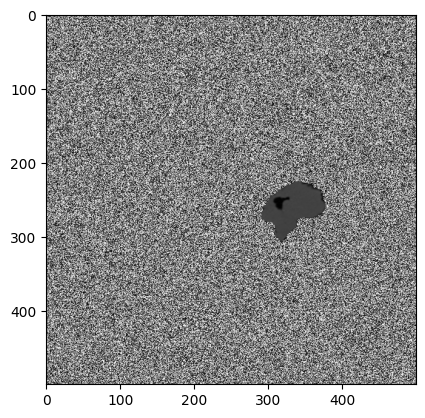

In [13]:
import matplotlib.pyplot as plt

neg_image_array = sitk.GetArrayFromImage(neg_image)

plt.imshow(neg_image_array[75,:,:], cmap='grey')